In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor

IBMQ.save_account('fb30d6ed3e7c1557fe60e36b2c8818ea67ec079e4bc1a9d0ab89b0be7f42fdaf7a7934f3354e4bd67069ea5b783bdb6fa2c7826015aead948821b4ace90f4cf4')

configrc.store_credentials:WARNING:2020-06-25 11:12:58,755: Credentials already present. Set overwrite=True to overwrite.


In [2]:
def completeGraphWalk(N,qreg,qcoin):
    qc = QuantumCircuit(qreg,qcoin,name='CompleteGraph')
    qc.swap(qreg[0:N],qcoin)
    return qc

def hadamardCoin(N,qc,qcoin):
    qc.h(qcoin)
    return qc

def grover3Coin(N,qc,qcoin):
    qc.h(qcoin)
    qc.x(qcoin)
    qc.h(qcoin[2])
    qc.toffoli(qcoin[0],qcoin[1],qcoin[2])
    qc.h(qcoin[2])
    qc.x(qcoin)
    qc.h(qcoin)
    qc.barrier()
    return qc

In [42]:
def markedList(markedList,N):
    oracleList = np.ones(2**N)
    for element in markedList:
        oracleList[element] = -1
    return oracleList.tolist()

def diffusion(N):
    qreg = QuantumRegister(N)
    qcoin = QuantumRegister(N)
    difCirc = QuantumCircuit(qreg,qcoin,name='Diffusion')
    difCirc.h(qcoin)
    
    aux = markedList([0],N)
    qcAux = oracle(aux,N,True)
    difCirc.append(qcAux,range(2*N))
    
    difCirc.h(qcoin)
    return difCirc


In [48]:
def oracle(markedList,N,dif):
    qreg = QuantumRegister(N)
    qcoin = QuantumRegister(N)
    qc = QuantumCircuit(qreg,qcoin,name='Oracle')
    if(dif==True):
        qc.diagonal(markedList,qcoin)
    else:
        qc.diagonal(markedList,qreg)

    return qc

def runWalk(qc,qreg,qcoin,creg,markedVertex,N,times):
    qc = QuantumCircuit(qreg,qcoin,creg)
    markedVertex=markedList(markedVertex,N)
    qcOracle = oracle(markedVertex,N,False)
    qcDif = diffusion(N)
    qcQWalk = completeGraphWalk(N,qreg,qcoin)
    qc.h(qreg)
    for i in range(times):
        qc.append(qcOracle,range(2*N))
        qc.barrier()
        qc.append(qcDif,range(2*N))
        qc.barrier()
        qc.append(qcQWalk,range(2*N))
        qc.barrier()

        
    qc = transpile(qc,basis_gates=['cx','u3','swap'],optimization_level=3)
    qc.measure(range(N),range(N))
        
    return qc

In [49]:
N=9

qreg = QuantumRegister(N)
qcoin = QuantumRegister(N)
creg = ClassicalRegister(N)

qc = QuantumCircuit(qreg,qcoin,creg)
#qc = diffusion(N)
times = int(np.sqrt(N))
limit = 2**N -1
print(limit)
qc = runWalk(qc,qreg,qcoin,creg,[0,1,int(limit/2),limit-1,limit],N,4)


    
#qc.draw(output='mpl')

511


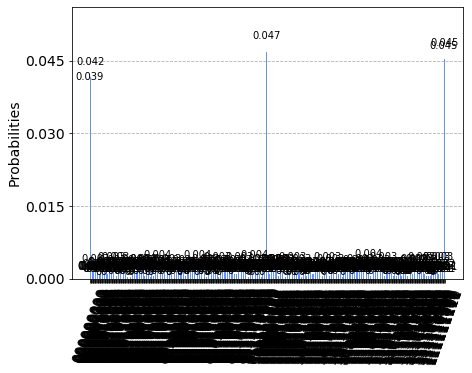

In [50]:

backend = Aer.get_backend('qasm_simulator')

job_sim = execute(qc, backend=backend,shots=3000)
result_sim = job_sim.result()
result_counts = result_sim.get_counts(qc)
plot_histogram(result_counts)

In [51]:
for key in result_counts:
    if(result_counts[key]>20):
        print(key, '->', result_counts[key])

000000000 -> 116
000000001 -> 125
011111111 -> 140
111111110 -> 134
111111111 -> 136


In [ ]:
ibm_backend = 'ibmq_ourense'
result_ibm = RealRunning(qc,ibm_backend)
#-- compared results
legend = ['QASM',ibm_backend]
plot_histogram([result_qasm,result_ibm], legend=legend)